In [1]:
!pip install efficientnet_pytorch
import numpy as np
import pandas as pd
import os
import json
import random
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from albumentations import *
from albumentations.pytorch import ToTensorV2

random_state = 42

random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0c75c7902f0abfddd45b10fe55cfdf04bafb23386e23d6a907ce7cce856743c9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
root = '/kaggle/input/weathertime-classification-with-road-images'

annotation = open(os.path.join(root,'train_dataset', 'train.json'))
data = json.load(annotation)
print('Total:', len(data['annotations']))

Total: 2600


In [3]:
train_ds = pd.json_normalize(data['annotations'])
train_ds.head()

,filename,period,weather
0,train_images\00001.jpg,Morning,Cloudy
1,train_images\00002.jpg,Afternoon,Cloudy
2,train_images\00003.jpg,Morning,Cloudy
3,train_images\00004.jpg,Morning,Sunny
4,train_images\00005.jpg,Afternoon,Cloudy


In [4]:
weather_encoder = LabelEncoder().fit(train_ds['weather'])

train_ds['weather'] = weather_encoder.transform(train_ds['weather'])
train_ds['filename'] = train_ds['filename'].str.replace('\\', '/', regex=True)

print(train_ds['weather'].value_counts())

0    1119
2     886
1     595
Name: weather, dtype: int64


In [5]:
x_train, x_test, y_train, y_test = train_test_split(train_ds['filename'].values, train_ds['weather'].values, 
                                                    shuffle=True, 
                                                    random_state=random_state, 
                                                    stratify=train_ds['weather'])

In [6]:
transforms = {
    x: Compose([
        Resize(224, 224),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_REPLICATE),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        OneOf([
            GaussianBlur(),
            GaussNoise(),
        ], p=0.2),

        Normalize(),
        ToTensorV2()
    ]) if x == 'train' else Compose([
        Resize(224, 224),
        
        Normalize(),
        ToTensorV2()
    ]) for x in ['train', 'test']
}

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files=image_files
        self.labels=labels
        self.transform=transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, i):
        image = np.array(Image.open(os.path.join(root, 'train_dataset', self.image_files[i])).convert('RGB'))
        labels = self.labels[i]
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, labels

In [8]:
sets = {
    'train': (x_train, y_train), 'test': (x_test, y_test)
}
datasets = {
    x: CustomDataset(sets[x][0], sets[x][1], transforms[x]) for x in sets.keys() 
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=8, num_workers=2, pin_memory=True) for x in sets.keys()
}

In [9]:
#model = EfficientNet.from_pretrained('efficientnet-b0')
model = torchvision.models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
epochs = 10

In [11]:
def train_fn(i, model, data_loader, loss_fn, optimizer, device):
    overall_loss = 0.
    
    with tqdm(data_loader, total=len(data_loader), desc=f'Training, phase {i} :') as loader:
        for data, weather in loader:
            optimizer.zero_grad()

            data, weather = data.to(device), weather.to(device)
            output = model(data)
            loss = loss_fn(output, weather)
            
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

            loader.set_postfix(loss=overall_loss / len(data_loader))
            

def validation_fn(i, model, data_loader, device):
    model.eval()
    
    weather_accuracy = 0.
    
    with tqdm(data_loader, total=len(data_loader), desc=f'Validating, phase {i} :') as loader:
        with torch.no_grad():
            for data, weather in loader:
                data, weather = data.to(device), weather.to(device)

                output = model(data)
                
                weather_accuracy += accuracy_score(weather.cpu().detach().numpy(), 
                                                   torch.argmax(output, dim=1).cpu().detach().numpy())

                loader.set_postfix(accuracy_weather=weather_accuracy / len(data_loader))
    model.train()

In [12]:
torch.cuda.empty_cache()
for epoch in range(1, epochs + 1):
    train_fn(epoch, model, dataloaders['train'], loss_fn, optimizer, device)
    validation_fn(epoch, model, dataloaders['test'], device)

Validating, phase 10 :: 100%|██████████| 82/82 [00:18<00:00,  4.52it/s, accuracy_weather=0.945]


(720, 1280, 3)
torch.Size([1, 3, 224, 224])
[1]


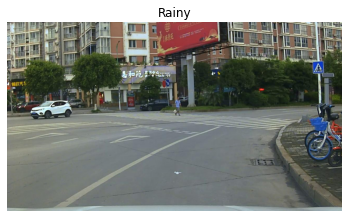

(720, 1280, 3)
torch.Size([1, 3, 224, 224])
[1]


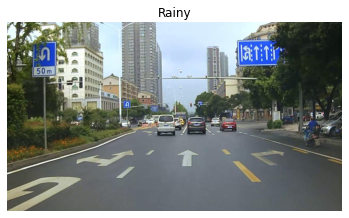

(720, 1280, 3)
torch.Size([1, 3, 224, 224])
[0]


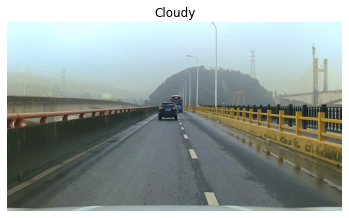

(1520, 2704, 3)
torch.Size([1, 3, 224, 224])
[1]


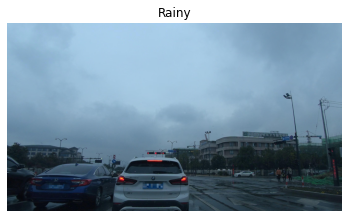

(1520, 2704, 3)
torch.Size([1, 3, 224, 224])
[1]


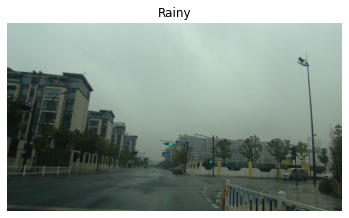

In [13]:
model.eval()

images = glob.glob(os.path.join(root, 'test_dataset', 'test_images', '*'))

for _ in range(5):
    image = np.array(Image.open(np.random.choice(images)).convert('RGB'))
    print(image.shape)
    
    tensor = transforms['test'](image=image)['image'].unsqueeze(0).to(device)
    print(tensor.shape)
    output = model(tensor)
    
    output = torch.argmax(output, dim=1).cpu().detach().numpy()
    print(output)
    plt.imshow(image)
    plt.title(f'{weather_encoder.inverse_transform(output)[0]}')
    plt.axis('off')
    plt.show()

In [14]:
filename = []
period = []
weather = []

for file in images:
    image = np.array(Image.open(file).convert('RGB'))
    
    tensor = transforms['test'](image=image)['image'].unsqueeze(0).to(device)
    output = model(tensor)
    
    output = torch.argmax(output, dim=1)

    filename.append(os.path.join(*file.rsplit('/', 2)[1:]).replace('/', '\\'))
    weather.append(output.item())

df = pd.DataFrame({'filename': filename,  
                   'weather': weather_encoder.inverse_transform(weather)}
                 ).sort_values('filename').reset_index(drop=True)

display(df)

,filename,weather
0,test_images\00008.jpg,Cloudy
1,test_images\00018.jpg,Cloudy
2,test_images\00020.jpg,Cloudy
3,test_images\00022.jpg,Sunny
4,test_images\00035.jpg,Cloudy
...,...,...
395,test_images\02970.jpg,Sunny
396,test_images\02973.jpg,Sunny
397,test_images\02976.jpg,Cloudy
398,test_images\02988.jpg,Sunny


In [15]:
data = df.to_json(orient='records')
js_df = {"root": {"annotations": json.loads(data)}}
with open('submission.json', 'w') as out:
    json.dump(js_df, out, indent=4)

In [16]:
torch.save(model.state_dict(), 'mobilenet_v3.pt')